<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import scipy.special
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
from torch.utils import data
import sys 
import time
import timeit

from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

print(device)



cuda


In [2]:
class Encoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2")
            
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
                    
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))   
        x = self.layers[-1](x)
        x = x/ torch.sqrt(2*torch.mean(x**2))
        return x

        
class Decoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2") 
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))
            
        x =  F.log_softmax(self.layers[-1](x), dim=-1 )
        return x

    
    
def awgn(x, snr):
    sigma = torch.tensor(np.sqrt(0.5/(10**(snr/10)))).to(device)
    noise = sigma * torch.randn(x.shape).to(device)
    x = x+noise 
    return x



In [3]:
M = 16**2
encoder = Encoder([M,10,10,4]).to(device)
decoder = Decoder([4,20,20,M]).to(device)

criterion= nn.NLLLoss()
para = list(encoder.parameters()) + list(decoder.parameters())
opt = Adam(para, lr=0.001)

start_time = time.time()
loss_sv = np.array([])

train_snr = 8.5

totEpoch = int(2e4)

t = tqdm(range(1,totEpoch+1), desc="loss")
for III in t:
    t.set_description("epoch={:.1f}".format(III))
    
    EbNo_r = 10**(train_snr/10)
    train_sigma = np.sqrt(1/(2*4*EbNo_r))
    
    mess = torch.randint(0,M,size=(25600,)).to(device)
    one_hot = F.one_hot(mess).float()
    tx = encoder(one_hot)

    rx = tx + (train_sigma*torch.randn(tx.shape)).to(device)

    y_pred = decoder(rx)
    cross_entropy = criterion(y_pred, mess) 
                                        
    opt.zero_grad()
    cross_entropy.backward()
    opt.step()

    loss_sv = np.append(loss_sv,cross_entropy.item())
         
         
  

epoch=20000.0: 100%|██████████| 20000/20000 [02:08<00:00, 155.14it/s]


In [4]:
# mess = torch.arange(M).to(device)
# one_hot = F.one_hot(mess).float()
# tx = encoder(one_hot)
# tx1 = tx.to('cpu').detach().numpy()
# np.txt('AE_4D_GS_const', tx1, delimiter=',')

In [5]:
SNR_dB = np.arange(0,15,1)


SER = np.array([])
R = 4
for snr in SNR_dB:
    EbNo_r = 10**(snr/10)
    test_sigma = np.sqrt(1/(2*4*EbNo_r))
    
    
    num_mess = 6400
    minErr = 2e3
    minSym = 1e6
    maxSym = minErr*1e4
    totSym = 0
    totErr = 0
    while  totErr<minErr and totSym<maxSym or totSym< minSym:
        mess = torch.randint(0,M,size=(num_mess,)).to(device)
        one_hot = F.one_hot(mess).float()
        tx = encoder(one_hot)
        
        rx = tx + (test_sigma*torch.randn(tx.shape)).to(device)
       
        y_pred = decoder(rx)
        
        m_hat = torch.argmax(y_pred, -1)
        
        err = torch.sum(torch.not_equal(mess, m_hat)).to('cpu').detach().numpy()
       
        totErr += err
        totSym += num_mess
    SER = np.append(SER, totErr/totSym)
        


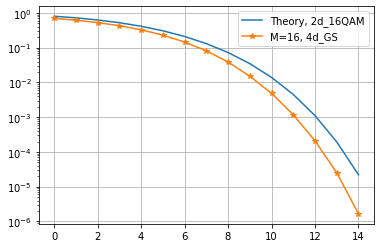

In [6]:

M_2d=16

snr_lin = R*10**((SNR_dB)/10)


SER_theory = 3/2* scipy.special.erfc(np.sqrt(snr_lin/10))
SER_theory = 1- (1 - SER_theory)*(1 -SER_theory)

plt.semilogy(SNR_dB,SER_theory,label='Theory, 2d_16QAM')
plt.semilogy(SNR_dB,SER,'-*',label='M={}, 4d_GS'.format(M_2d))
plt.legend()
plt.grid(True)


In [7]:
print(SER_theory)
print(SER)

[8.03431959e-01 7.22674910e-01 6.28189583e-01 5.23433083e-01
 4.13969683e-01 3.07058984e-01 2.10541495e-01 1.31127950e-01
 7.26095345e-02 3.48142879e-02 1.39839722e-02 4.51254656e-03
 1.10896189e-03 1.93860887e-04 2.21055418e-05]
[6.94678543e-01 6.17244228e-01 5.27562699e-01 4.29351115e-01
 3.27708997e-01 2.30906648e-01 1.45270701e-01 8.15216959e-02
 3.87300955e-02 1.51144506e-02 4.85469745e-03 1.17774906e-03
 2.08890374e-04 2.52000000e-05 1.65000000e-06]
